In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.svm import SVC
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed
import itertools


To begin the analysis of the regression of the amount of capital recovered from charged off loans first
we define some functions which will help reduce the amount of recycled code. 

In [2]:
# Return the explained variance score given some test data. 
def my_score(clf, X_test, y_test):
    '''
        Predict using trained scikit-learn estimator and compute the explained variance score  
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of columns as X_test
        
        Returns:
        
        Explained variance score of predicted data
        
    '''
    y_predict = clf.predict(X_test)
    return explained_variance_score(y_test, y_predict)

# Return multiple scores and plot predicted vs. true. 
def classifier_analysis(clf, X_test, y_test):
    
    '''
        Predict using trained scikit-learn estimator and compute and plot various metrics:
        Prints 
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of columns as X_test
        
        target_transformer_ : scikit-learn scaler such as QuantileTransformer(), MinMaxScaler(), etc.
        
    
        
        Returns:
        
        y_test : ndarray (n_samples, )
            
            Same as input for convenience
        
        y_predict : ndarray (n_samples, ) 
            
            Predictions 
        
    '''
    
    y_predict = clf.predict(X_test)
    
    # Print the mean squared error and explained variance
    mse_ = mean_squared_error(y_test, y_predict)
    evs_ = explained_variance_score(y_test, y_predict)
    print('Mean squared error {}'.format(mse_))
    print('Explained variance score {}'.format(evs_))

    # Plot true vs. predicted as scatter plot. 
    ym = np.max(y_test)
    fig = plt.figure()
    plt.scatter(y_test, y_predict, s=1)
    plt.plot([0, ym],[0, ym],color='r')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    plt.grid()
    plt.xlim([0, 1.1*ym])
    plt.ylim([0, 1.1*ym])
    _ = plt.show()
    
    return y_test, y_predict

In [3]:
# Convert date-like + 'Missing' valued features to one-hot encoded columns; uses KBins on the years of the date-like, which 
# bins then one-hot encodes, while also one-hot encoding 'Missing' separately. 
def encode_dates_and_missing(df):
    
    '''
    A DataFrame which takes mixed "Missing" and datetime values, separates out the "Missing"
    and then performs two operations. First, the 'Missing' column is one-hot encoded, second,
    the datetime variables are binned and encoded using KBinsDiscretizer, using a uniform bin
    width strategy. 

    Parameters:

    df : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    Returns:

    encoded_df : DataFrame (n_samples, (undetermined size))
    
        Encoded dataframe, filled with one-hot encoded columns of the input DataFrame. 
            
            
            
    '''
    
    for i, seriesname in enumerate(df.columns):
        series = df[seriesname]
        series_missing = pd.get_dummies(series[series=='Missing'])
        series_notmissing = series[series!='Missing']
        notmiss_index = series_notmissing.index
        
        kbd = KBinsDiscretizer(n_bins=3, strategy='uniform')
        series_dt = pd.to_datetime(series_notmissing).dt.year
        encoded_series = kbd.fit_transform(series_dt.values.reshape(-1,1))
        encoded_series = pd.DataFrame(kbd.fit_transform(series_dt.values.reshape(-1,1)).toarray(), index=notmiss_index).astype(int)
        encoded_series = encoded_series.join(series_missing, how='outer').fillna(value=0)
        encoded_series.columns = [seriesname+'_'+str(col) for col in encoded_series.columns]
        encoded_series = encoded_series.iloc[:, 1:]
        if i == 0: 
            encoded_df = encoded_series
        else:
            encoded_df = pd.concat((encoded_df,encoded_series),axis=1)
            
    return encoded_df
    

In [4]:
def my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler()):
    ''' Transform features using a column transformer. 
    
    A DataFrame which takes mixed "Missing" and datetime values, separates out the "Missing"
    and then performs two operations. First, the 'Missing' column is one-hot encoded, second,
    the datetime variables are binned and encoded using KBinsDiscretizer, using a uniform bin
    width strategy. 

    Parameters
    ----------

    X : DataFrame (n_samples, n_features)
         
        Dataframe which contains training data. 

    num_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain numerical features.
         

    cat_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
    date_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    num_transformer : scikit-learn Transformer
         
        scikit-learn scaler such as QuantileTransformer(), MinMaxScaler(), etc.

    Returns
    -------

    col_transformer : ColumnTransformer instance
    
         Transformer that can be used to rescale and encode data. 
            
    '''
    
    uniq_categories = [list(np.sort(X[col].unique()))+['Missing','Unknown'] for col in cat_features]

    cat_transformer = OneHotEncoder(categories=uniq_categories, drop='first')
    
    if date_features is None:
        col_transformer = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                                          ('cat', cat_transformer, cat_features)])
    else:
        col_transformer = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                                          ('cat', cat_transformer, cat_features),
                                                         ('my_kbd', 'passthrough', date_features)])

    return col_transformer

    
def scale_features(col_transformer_, X_train, X_test, pca=None):
    '''
    Fits ColumnTransformer() to feature training data and then 
    transforms train and test data. 

    Parameters:

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode data.

    X_train : ndarray or DataFrame (n_samples, n_features)
    
        Feature data to scale. 

    X_test : ndarray (test_samples, n_features)
    
        Target data to scale. 

    Returns:

    X_train_scaled : ndarray or DataFrame (n_samples, n_features)
    
        Scaled training data.

    X_test_scaled : ndarray (test_samples, n_features)
    
        Scaled test data.            
            
            
    '''
    _ = col_transformer_.fit(X_train)
    X_train_scaled = col_transformer_.transform(X_train)
    X_test_scaled = col_transformer_.transform(X_test)
    
    if pca is not None:
        pcatransformer = PCA(n_components=pca)
        _ = pcatransformer.fit(X_train_scaled.toarray())
        X_train_scaled = pcatransformer.transform(X_train_scaled.toarray())
        X_test_scaled = pcatransformer.transform(X_test_scaled.toarray())
    
    return X_train_scaled, X_test_scaled

def scale_target(target_transformer_, y_train, y_test):
    '''
    Fits transformer to target training data and then 
    transforms target train and target test data. 

    Parameters:

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.

    y_train : ndarray or DataFrame (n_samples, )
    
        Target training data to scale. 

    y_test : ndarray (test_samples, )
    
        Target testing data to scale. 

    Returns:

    y_train_scaled : ndarray or DataFrame (n_samples, n_features)
    
        Scaled training data.

    y_test_scaled : ndarray (test_samples, n_features)
    
        Scaled test data.   
            
    '''
    _ = target_transformer_.fit(y_train.reshape(-1,1))
    y_train_scaled = target_transformer_.transform(y_train.reshape(-1,1))
    y_test_scaled = target_transformer_.transform(y_test.reshape(-1,1))    
    return y_train_scaled.ravel(), y_test_scaled.ravel()

# This isn't cross validation its just model training. Cross-validation averages over the trained models of a parameter value
def my_cross_validate(estimator, col_transformer_, target_transformer_, X_traintest, y_traintest, param_grid, pca=None):
    '''
    Custom cross validation procedure which computes KFold cross validation (5 folds) for sets of parameters
    over training and testing data. Runs in parallel using joblib. 

    Parameters:

    estimator : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode feature data.

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.
                  
    X_traintest : ndarray, DataFrame (n_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_traintest : ndarray (n_samples, )
         
        Array containing the training and testing data of the target variable. 
        
    param_grid : dict
         
        scikit-learn style parameter grid; dict whose keys are strings and whose values are sensible
        values for the corresponding keyword arguments of the scikit-learn estimator denoted by estimator.
        Values can be singular values or lists of values.

    Returns:

    estimator : scikit-learn Regressor
    
        Best model after cross validation
            
            
            
    '''
    mean_scores = []
    # cv_params needs to make sense for the estimator given
    param_grid_list = param_grid_iterable(param_grid)
    for params_ in param_grid_list:
        with Parallel(n_jobs=-1) as parallel:
            fitted_models_and_test_splits = parallel(delayed(fit_model_)
                                                     (estimator(**params_), col_transformer_, target_transformer_,
                                                          X_traintest, y_traintest, train, test, pca=pca)
                                  for (train, test) in KFold(n_splits=5).split(X_traintest, y_traintest))
            
            # Get averages (explained variance) score for this model
            scores = parallel(delayed(my_score)(model_, xt, yt) for (model_, xt, yt) in fitted_models_and_test_splits) 
            mean_scores += [np.mean(list(scores))]
            
    
    best_params_ = param_grid_list[np.argmax(np.array(mean_scores))]
    return estimator(**best_params_) 


def fit_model_(estimator, col_transformer_, target_transformer_, X_traintest, y_traintest, train, test, pca=None):
    '''
    

    Parameters:

    estimator : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode feature data.

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.
                  
    X_traintest : ndarray, DataFrame (n_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_traintest : ndarray (n_samples, )
         
        Array containing the training and testing data of the target variable. 
        
    param_grid : dict
         
        scikit-learn style parameter grid; dict whose keys are strings and whose values are sensible
        values for the corresponding keyword arguments of the scikit-learn estimator denoted by estimator.
        Values can be singular values or lists of values.

    Returns:

    (estimator, X_test, y_test) : tuple
    
        Tuple consisting of the fitted estimator and testing data sets (for convenience).
            
    '''
    X_train, X_test = X_traintest.loc[train,:], X_traintest.loc[test,:]
    y_train, y_test = y_traintest.loc[train].values.ravel(), y_traintest.loc[test].values.ravel()
    
    X_train, X_test  = scale_features(col_transformer_, X_train, X_test, pca=pca)
    y_train, y_test = scale_target(target_transformer_, y_train, y_test)

    _ = estimator.fit(X_train, y_train)    
    return (estimator, X_test, y_test)

def param_grid_iterable(params):
    '''
    Converts scikit-learn style parameter grid to tuples of 
    
    Parameters:

    params : dict
         
        Dictionary of the same style as scikit-learn parameter grid. 

    Returns:
    
    cvsorted : list
        
        List of combinations (dict) of parameter values. 

    '''
    keys = sorted(params)
    combinations = list(itertools.product(*(params[key] if type(params[key]) in [list, dict, np.ndarray] else [params[key]]
                                            for key in keys)))
    cvsorted = [dict(zip(len(c)*keys, c)) for c in combinations]
    return cvsorted

In [5]:
def cross_validated_model(estimator, col_transformer_, target_transformer_, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, param_grid, pca=None):
    '''
    Parameters:

    estimator : DataFrame (n_samples, n_features)
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    col_transformer : ColumnTransformer instance
    
        Transformer that can be used to rescale and encode feature data.

    target_transformer_ : scikit-learn preprocessing scaler
    
        Transformer that can be used to rescale and encode target data.
                  
    X_traintest : ndarray, DataFrame (n_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_traintest : ndarray (n_samples, )
         
        Array containing the training and testing data of the target variable. 
        
    X_holdout : ndarray, DataFrame (n_holdout_samples, n_features)
         
        Array containing the training and testing data of the feature variable. 

    y_holdout : ndarray (n_holdout_samples, )
         
        Array containing the training and testing data of the target variable.
        
    param_grid : dict
         
        scikit-learn style parameter grid; dict whose keys are strings and whose values are sensible
        values for the corresponding keyword arguments of the scikit-learn estimator denoted by estimator.
        Values can be singular values or lists of values.

    Returns:

    (estimator, X_holdout_final, y_holdout_final) : tuple
    
        Tuple consisting of the fitted estimator and scaled, hold out data sets. 
            
    '''
    # Initialize the cross-validation method
    kf = KFold(n_splits=2)
    
    # Using joblib, run my cross validation function; it scales feature and target data in the correct way 
    # in combination with cross validation.
    best_model_ = my_cross_validate(estimator, col_transformer_, target_transformer_, X_traintest, y_traintest, param_grid)
    
    # Using all of the traintest data; transform both the traintest and holdout data sets.
    X_traintest_final, X_holdout_final = scale_features(col_transformer_, X_traintest, X_holdout)
    y_traintest_final, y_holdout_final = scale_target(target_transformer_, y_traintest.values.ravel(), y_holdout.values.ravel())

    _ = best_model_.fit(X_traintest_final, y_traintest_final)
        
#     # Print final scores and plot the y_true vs y_pred
#     classifier_analysis(best_model_, X_holdout_final, y_holdout_final)
    
    return (best_model_, X_holdout_final, y_holdout_final)

### 1. Reformulate the hypothesis

The original idea of this stage of the project was to create a predictive model for the amount of money recovered from a charged off loan. The problem with this is that there is no indication, however, as to the total outstanding amount of money *currently* owed. Unfortunately the outstanding principal isn't recorded because once a loan is charged off, there is technically no outstanding principal. 

This is a problem as the model was supposed to predict the amount of money that ***could*** be recovered from each charged off loan. If the model predicts amounts that are greater than the total possible amount, then it isn't a very useful model. Therefore, when producing the model, it either has to be interpreted only as a rough estimate, or something else needs to be done to ensure that the predicted variable always has a sensible interpretation. The latter is obviously a better choice and as such that is what is pursued here.

The hypothesis needs to be modified; changing from

    *How much money from charged off loans will be recovered?*
    
To:

    *What percentage of the principal still owed will be recovered?"


### 2. Construction of a new target variable.
To accomodate this fact, we calculate the outstanding principal that could be recovered from charged off loans by subtraction of the total received principal from the loan amount. This model disregards financial constructions like interest and late fees. This is done for multiple reasons

    1. There is no indication as to how much capital is owed in the form of late fees and interest
    2. There is no upper bound on the amount of interest and late fees that could be owed
    3. The late fees and interest accrue over time. 
    2. The model should incorporate as much data in the modeling process as possible
    3. The principal is actually funded by the company or investors; it contributes to actual loss

In the construction of the new target variable, it is beneficial to involve as little data as possible (such as interest and late fee data), as it won't be able to be used to train the model. Therefore, the target variable we construct is the ratio of the net recovered amount to the outstanding principal.
Originally thought of doing loan amount - total payments, but total payments includes interest and late fees so this quantity can be negative and hence nonsensical. The equation for the new target variable is then

<h3 align="center">
$ \text{Percentage recovered} = \: \frac{\text{Recovery amount} - \text{Collection Fees}}{\text{Loan amount}-\text{Principal amount received}}$
</h3> 

It turns out what was written above is terrible.

The modeling in this notebook is regression of a continuous variable. There are many categorical type variables which
need to be encoded in order to be used for regression. There are a number of categorical variables with a large (100+) number of categories. There is 

In [6]:
loan_data = pd.read_csv('regression_loan_data.csv',index_col=False)

#Still contains missing values; first, drop features with missing values (dropping samples leaves us with no data).
loan_data = loan_data.dropna(axis=1)

There are twenty loans whose principal amount has been paid off; remove these from the dataset.

In [7]:
# regression_data = loan_data
# net_recovery = regression_data.recoveries  - regression_data.collection_recovery_fee
# remaining_principal = regression_data.loan_amnt  - regression_data.total_rec_prncp

# # remaining_principal = remaining_principal[remaining_principal > 0]
# net_recovery = net_recovery[remaining_principal.index]
# target = net_recovery / (remaining_principal)

# # target = target[target < 1]
# regression_data = regression_data.loc[target.index, :]

# # Assign target/training variables
# # y = target
# # X = regression_data.loc[y.index,:]
# # X = regression_data.drop(columns=['recoveries']).loc[y.index,:]
# # X = regression_data.drop(columns=['recoveries','loan_amnt','collection_recovery_fee','total_rec_prncp']).loc[y.index,:]

Target variables greater than one at this point indicate that most of the recoveries were made on interest and late fees and as such shouldn't be used to create our model. 

Our prediction is occuring in the present moment. All of the data corresponding to charged-off loans can be used, and it does not have to be treated as a time series, as we are not trying to predict the future.

The modeling in this notebook is regression of a continuous variable. There are many categorical type variables which
need to be encoded (transformed to numerical values) in order to be used for regression. A portion of these variables have a large (100+) number of categories.

In [8]:
loan_data.select_dtypes(include='object').nunique().sort_values(ascending=False).head(10)

zip_code                     900
earliest_cr_line             686
sec_app_earliest_cr_line     451
issue_d                      137
last_pymnt_d                 132
last_credit_pull_d           114
settlement_date               89
debt_settlement_flag_date     83
addr_state                    51
sub_grade                     35
dtype: int64

The largest number of categories belongs to the zip code variable; which is reported as the first three digits (followed by 'xx'). We can reduce the number of categories by aggregating by the first *two* digits; but if we do this it is almost nearly
the same as identifying by the state; In fact, roudning to two digits is actually less specific than identifying by the state. We already have the state in 'addr_state' feature data so there is no motivation to keep the zip codes; if we're going to reduce it to two digits.

As can be seen, the variables with the second to eight largest number of categories are related to dates; These features, from the cleaning process, are a mixture of dates (month-year) and the category 'Missing'. These variables will be encoded using binning, specifically KBinsDiscretizer using the One-hot encoding strategy with a small number of bins per feature vector. The manner with which we bin is to represent the dates by their year, and then use a uniform bin-width strategy with three bins.

Simultaneously, the "Missing" values are one-hot-encoded separately, such that the result is three bins for the date's years and an additional bin for the 'Missing' Category.

In summary the process is as follows: separate date-like and 'Missing' values. One-hot encode 'Missing' and dates binned by year separately.

In [9]:
loan_data = loan_data.drop(columns='zip_code')

In [10]:
date_features = ['last_pymnt_d', 'debt_settlement_flag_date',
                 'last_credit_pull_d', 'issue_d', 'settlement_date',
                 'hardship_start_date','sec_app_earliest_cr_line',
                 'hardship_end_date', 'payment_plan_start_date', 'earliest_cr_line']

In [11]:
date_df = loan_data[date_features]
date_data = encode_dates_and_missing(date_df)
num_and_cat_data = loan_data.drop(columns=date_features)

In [12]:
# Assign target/training variables
y = num_and_cat_data.recoveries
num_and_cat_data = num_and_cat_data.drop(columns=['recoveries'])#.loc[y.index,:]

In [13]:
num_features = num_and_cat_data.select_dtypes(exclude=['object']).columns
cat_features = num_and_cat_data.select_dtypes(include=['object']).columns
date_features = date_data.columns

X = pd.concat((num_and_cat_data, date_data),axis=1)
# X = num_and_cat_data

Default cross validation is KFold with 5 folds; by default shuffling is off so we technically do not need to pass a random state.

In [14]:
X_traintest, X_holdout, y_traintest, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

X_traintest = X_traintest.reset_index(drop=True)
X_holdout = X_holdout.reset_index(drop=True)
y_traintest = y_traintest.reset_index(drop=True)
y_holdout = y_holdout.reset_index(drop=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size=0.2, random_state=42)

In [16]:
col_transformer_ = my_feature_transformer(X, num_features, cat_features, None, num_transformer=StandardScaler())
_ = col_transformer_.fit(X_train)

X_train_transformed = col_transformer_.transform(X_train)
X_test_transformed = col_transformer_.transform(X_test)

In [17]:
print('Shape of the training set {} and testing set {} after transformation'.format(X_train_transformed.shape,
                                                                                    X_test_transformed.shape))

Shape of the training set (167459, 210) and testing set (41865, 210) after transformation


Preliminary tests to ensure that nothing outrageously wrong with preprocessing.

Mean squared error 562.5999318419497
Explained variance score 0.9998288270508452


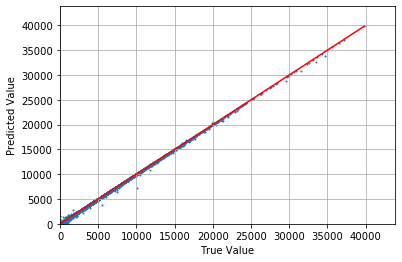

In [19]:
col_transformer_ = my_feature_transformer(X, num_features, cat_features, None, num_transformer=StandardScaler())
_ = col_transformer_.fit(X_traintest)

X_traintest_transformed = col_transformer_.transform(X_traintest)
sgd = SGDRegressor(random_state=42)
_ = sgd.fit(X_traintest_transformed, y_traintest)
ysgd, ysgd_predict = classifier_analysis(sgd, X_traintest_transformed, y_traintest)

Mean squared error 638.8592148339226
Explained variance score 0.9998028668021222


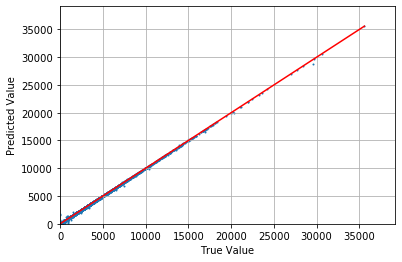

In [18]:
sgd = SGDRegressor(random_state=42)
_ = sgd.fit(X_train_transformed, y_train)
ysgd, ysgd_predict = classifier_analysis(sgd, X_test_transformed, y_test)

### Model training and analysis



#### Preliminary tests

For each model we make a preliminary test on the training data; this is similar to the no-information rate type
analysis in classification problems. That is, we train and test with the same data set. If the model is inaccurate
in this case then there is something seriously wrong with the data or the model. 

For these tests we shall leave the target variable untransformed; the features need to be transformed to
format the categorical variables accordingly. While there are an incredible number of options for fine tuning 
the main investigation is into the efficacy of the numerical feature transformers. 

In [20]:
sgd_ss_col_transformer_ = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())

ridge_ss_col_transformer_ = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())

sgd_ss = cross_validated_model(SGDRegressor, sgd_ss_col_transformer_, StandardScaler(), X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'random_state':42, 'alpha':[0.001, 0.01, 0.1]}, pca=10)

ridge_ss = cross_validated_model(Ridge, ridge_ss_col_transformer_, StandardScaler(), X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':[0.1, 1, 10]}, pca=10)

Mean squared error 0.005341301055098696
Explained variance score 0.9949424410507993


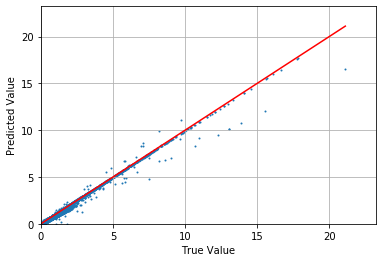

Mean squared error 0.0008461373679167879
Explained variance score 0.9991988326639973


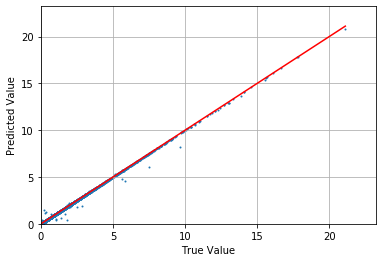

In [21]:
_ = classifier_analysis(*sgd_ss)

y_ss, y_ss_predict = classifier_analysis(*ridge_ss)

In [22]:
no_pca_sgd_ss_col_transformer_ = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())

no_pca_ridge_ss_col_transformer_ = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())

no_pca_sgd_ss = cross_validated_model(SGDRegressor, no_pca_sgd_ss_col_transformer_, StandardScaler(), X_traintest, 
                                      y_traintest, X_holdout, y_holdout, {'random_state':42, 'alpha':[0.001, 0.01, 0.1]}, pca=None)

no_pca_ridge_ss = cross_validated_model(Ridge, no_pca_ridge_ss_col_transformer_, StandardScaler(), X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':[0.1, 1, 10]}, pca=None)

Mean squared error 0.005341301055098696
Explained variance score 0.9949424410507993


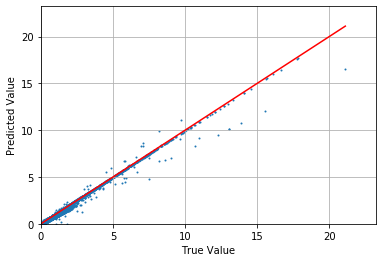

Mean squared error 0.0008461373679167879
Explained variance score 0.9991988326639973


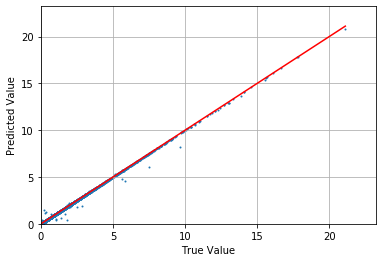

In [23]:
_ = classifier_analysis(*no_pca_sgd_ss)

no_pca_y_ss, no_pca_y_ss_predict = classifier_analysis(*no_pca_ridge_ss)

Mean squared error 694.7694983628935
Explained variance score 0.9997863740103625


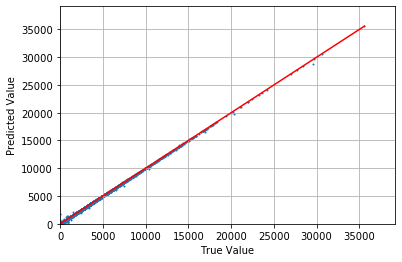

In [24]:
sgd_test = SGDRegressor(tol=1e-7)

col_transformer_ = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())
_ = col_transformer_.fit(X_train)

X_train2 = col_transformer_.transform(X_train)
X_test2 = col_transformer_.transform(X_test)

# pcatransformer = PCA(n_components=5)
# _ = pcatransformer.fit(X_train2.toarray())
# xt_pca = pcatransformer.transform(X_train2.toarray())
# xtest_pca =  pcatransformer.transform(X_test2.toarray())

xt_pca = X_train2
xtest_pca =  X_test2

yt_pca = y_train.values.ravel()
ytest_pca = y_test.values.ravel()

# target_transformer_2 = StandardScaler()
# _ = target_transformer_2.fit(y_train2.reshape(-1, 1))
# yt_pca = target_transformer_2.transform(y_train2.reshape(-1, 1))
# ytest_pca = target_transformer_2.transform(y_test2.reshape(-1, 1))

_ = sgd_test.fit(xt_pca, yt_pca.ravel())
_ = classifier_analysis(sgd_test, xtest_pca, ytest_pca.ravel())

Mean squared error 583.8838368075508
Explained variance score 0.9998223310118901


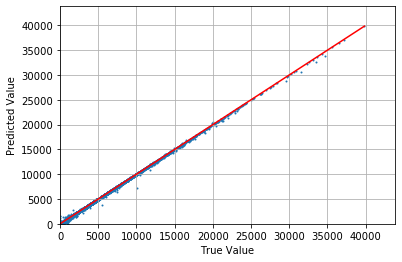

In [29]:
sgd_test = SGDRegressor(tol=1e-7)

col_transformer_ = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())

_ = col_transformer_.fit(X_traintest)

xt = col_transformer_.transform(X_traintest)

pcatransformer = PCA(n_components=1)
_ = pcatransformer.fit(xt.toarray())
xt_pca = pcatransformer.transform(xt.toarray())
# X_test_scaled = pca.transform(X_test_scaled)

_ = sgd_test.fit(xt, y_traintest.values.ravel())

_ = classifier_analysis(sgd_test, xt, y_traintest.values.ravel())

In [31]:
X_holdout = col_transformer_.transform(X_holdout)

In [38]:
X_holdout.toarray()

array([[-0.37524267, -0.37445705, -0.37132317, ...,  1.        ,
         0.        ,  1.        ],
       [-1.19893585, -1.19846916, -1.19494662, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.64138546,  1.64295191,  1.64229415, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.50525694,  0.50638348,  0.50910189, ...,  1.        ,
         0.        ,  1.        ],
       [-1.085323  , -1.08481232, -1.08134338, ...,  1.        ,
         0.        ,  1.        ],
       [-0.34683946, -0.34604284, -0.34292236, ...,  1.        ,
         1.        ,  0.        ]])

In [40]:
X_traintest.shape

(209324, 68)

In [41]:
X_holdout.shape

(52331, 238)

In [39]:
X_holdout_pca = pcatransformer.transform(X_holdout.toarray())
_ = classifier_analysis(sgd_test, X_holdout_pca, y_holdout.values.ravel())

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 238 is different from 1)

Remember that this is testing the training data only.

In [ ]:
ridge_test = Ridge()

_ = col_transformer_.fit(X_traintest)

xt = col_transformer_.transform(X_traintest)

_ = ridge_test.fit(xt, y_traintest)

_ = classifier_analysis(ridge_test, xt, y_traintest)

It's quite clear that there is something wrong with the stochastic gradient descent; as we shall see this can be improved by
rescaling of the data.

While cross validation over various parameters is performed the main comparisons are made between the various choices
of numerical transformers; that is, the investigation here considers the four choices of combinations of QuantileTransformer()
and MinMaxScaler() for the feature and target data. This could and probably should be handled by nested cross validation. I look at some preliminary results to see if there is anything disastrously wrong with any of the transformer selections.  

First, define the transformer instances; we can reuse these as we are transforming the same target and train data in each instance.

In [ ]:
col_transformer_m = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=MinMaxScaler())

col_transformer_q = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=QuantileTransformer())

target_transformer_m = MinMaxScaler()

target_transformer_q = QuantileTransformer()

The first choice is to use MinMaxScaler on both the target and feature data. 

In [ ]:
col_transformer_m = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=MinMaxScaler())

target_transformer_m = MinMaxScaler()

sgd_mm = cross_validated_model(SGDRegressor, col_transformer_m, target_transformer_m, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'random_state':42, 
                                                                      'tol':[1e-1, 1e-3, 1e-5], 'penalty':['elasticnet','l2']})

ridge_mm = cross_validated_model(Ridge, col_transformer_m, target_transformer_m, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':[0.1, 1, 10], 'tol':[1e-1, 1e-3, 1e-5]})

In [ ]:
_ = classifier_analysis(*sgd_mm, target_transformer_m)

y_mm, y_mm_predict = classifier_analysis(*ridge_mm, target_transformer_m)

In [ ]:
y_mm_predict_unscaled = target_transformer_m.inverse_transform(y_mm_predict.reshape(-1, 1))
y_mm_unscaled = target_transformer_m.inverse_transform(y_mm.reshape(-1, 1))

mse_ = mean_squared_error(y_mm_unscaled, y_mm_predict_unscaled)
evs_ = explained_variance_score(y_mm_unscaled, y_mm_predict_unscaled)
print('Mean squared error {}'.format(mse_))
print('Explained variance score {}'.format(evs_))

ymaxmm_unscaled = np.max(y_mm_unscaled)
fig = plt.figure()
plt.scatter(y_mm_unscaled, y_mm_predict_unscaled, s=1)
plt.plot([0, ymaxmm_unscaled],[0, ymaxmm_unscaled],color='r')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')
plt.grid()
plt.xlim([0, 1.1*ymaxmm_unscaled])
plt.ylim([0, 1.1*ymaxmm_unscaled])
_ = plt.show()

The above plots represent results from scaling with MinMaxScaler on both feature and target data. 

    1. The prediction vs. true values for stochastic gradient descent
    2. The prediction vs. true values for ridge regression
    3. The ridge regression results from (2) mapped back to the original, unscaled space.

Next is to use a Quantile transformer on the feature data and minmax scaler on the target data

In [ ]:
col_transformer_s = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())

target_transformer_s = StandardScaler()

sgd_ss = cross_validated_model(SGDRegressor, col_transformer_s, target_transformer_s, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'random_state':42, 
                                                                      'tol':[1e-1, 1e-3, 1e-5], 'penalty':['elasticnet','l2']})

ridge_ss = cross_validated_model(Ridge, col_transformer_s, target_transformer_s, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':[0.1, 1, 10], 'tol':[1e-1, 1e-3, 1e-5]})

In [ ]:
_ = classifier_analysis(*sgd_ss, target_transformer_s)

y_ss, y_ss_predict = classifier_analysis(*ridge_ss, target_transformer_s)

In [ ]:
col_transformer_q = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=QuantileTransformer())

target_transformer_m = MinMaxScaler()

sgd_qm = cross_validated_model(SGDRegressor, col_transformer_q, target_transformer_m, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'random_state':42, 
                                                                      'tol':[1e-1, 1e-3, 1e-5], 'penalty':['elasticnet','l2']})

ridge_qm = cross_validated_model(Ridge, col_transformer_q, target_transformer_m, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':[0.1, 1, 10], 'tol':[1e-1, 1e-3, 1e-5]})

In [ ]:
_ = classifier_analysis(*sgd_qm, target_transformer_m)

y_qm, y_qm_predict = classifier_analysis(*ridge_qm, target_transformer_m)

y_qm = target_transformer_m.inverse_transform(y_qm.reshape(-1, 1))
y_qm_predict = target_transformer_m.inverse_transform(y_qm_predict.reshape(-1, 1))

ymaxqm = np.max(y_qm)
fig = plt.figure()
plt.scatter(y_qm, y_qm_predict, s=1)
plt.plot([0, ymaxqm],[0, ymaxqm],color='r')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')
plt.grid()
plt.xlim([0, 1.1*ymaxqm])
plt.ylim([0, 1.1*ymaxqm])
_ = plt.show()

Next is to use QuantileTransformer on the target and MinMax on the feature

In [ ]:
col_transformer_m = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=MinMaxScaler())

target_transformer_q = QuantileTransformer()

sgd_mq = cross_validated_model(SGDRegressor, col_transformer_m, target_transformer_q, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'random_state':42, 
                                                                      'tol':[1e-1, 1e-3, 1e-5], 'penalty':['elasticnet','l2']})

ridge_mq = cross_validated_model(Ridge, col_transformer_m, target_transformer_q, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':[0.1, 1, 10], 'tol':[1e-1, 1e-3, 1e-5]})

In [ ]:
_ = classifier_analysis(*sgd_mq, target_transformer_q)

y_mq, y_mq_predict = classifier_analysis(*ridge_mq, target_transformer_q)

y_mq_predict = target_transformer_q.inverse_transform(y_mq_predict.reshape(-1, 1))
y_mq = target_transformer_q.inverse_transform(y_mq.reshape(-1, 1))

ymaxmq = np.max(y_mq)
fig = plt.figure()
plt.scatter(y_mq, y_mq_predict, s=1)
plt.plot([0, ymaxmq],[0, ymaxmq],color='r')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')
plt.grid()
plt.xlim([0, 1.1*ymaxmq])
plt.ylim([0, 1.1*ymaxmq])
_ = plt.show()

The final pair uses QuantileTransformer on both the target and feature data. 

In [ ]:
col_transformer_q = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=QuantileTransformer())

target_transformer_q = QuantileTransformer()

sgd_qq = cross_validated_model(SGDRegressor, col_transformer_q, target_transformer_q, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'random_state':42, 
                                                                      'tol':[1e-1, 1e-3, 1e-5], 'penalty':['elasticnet','l2']})

ridge_qq = cross_validated_model(Ridge, col_transformer_q, target_transformer_q, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':[0.1, 1, 10], 'tol':[1e-1, 1e-3, 1e-5]})

In [ ]:
_ = classifier_analysis(*sgd_qq, target_transformer_q)

y_qq, y_qq_predict = classifier_analysis(*ridge_qq, target_transformer_q)
y_qq_predict = target_transformer_q.inverse_transform(y_qq_predict.reshape(-1, 1))
y_qq = target_transformer_q.inverse_transform(y_qq.reshape(-1, 1))

ymaxqq = np.max(y_qq)

fig = plt.figure()
plt.scatter(y_qq, y_qq_predict, s=1)
plt.plot([0, ymaxqq],[0, ymaxqq],color='r')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')
plt.grid()
plt.xlim([0, 1.1*ymaxqq])
plt.ylim([0, 1.1*ymaxqq])
_ = plt.show()

In every case the Ridge regression outperforms the stochastic gradient descent. It is also clear that it is best to use the same transformer on the feature and target data; perhaps something that should have been obvious. 


The worst result by far occurs when the MinMaxScaler() is applied to the features and the quantile transformer is applied to the target data: Not only do the models have the worst predictions but upon transformation to the original target space we see that there are a number of transformations which are "maxxed out", producing predictions that are nearly equal the maximum recovered amount for the whole dataset. The issue with this is that it is likely that these values are above the total amount of money that could possibly be recovered. This is a dangerous red herring; if this model were used it would cause nonsensical drastic estimations.

Simple comparison of the true to predicted values of the uniform application of MinMaxScaler() and QuantileTransformer() lead to very similar results.

| Scaling | Mean-squared error | Estimated variance |
| --- | --- | --- |
| QuantileTransformer | 5.1584e-09 | 0.999998|
| MinMaxScaler | 3.94e-07 | 0.999997|

The QuantileTransformer() is slightly better in both metrics BUT this is misleading because upon transformation back to the
original target space shows that the QuantileTransformer results in much worse predictions than the MinMaxScaler results. In
fact, the MinMaxScaler results are almost perfect. 

In [ ]:
print(mean_squared_error(y_mm, y_mm_predict), mean_squared_error(y_qq, y_qq_predict))
print(explained_variance_score(y_mm, y_mm_predict), explained_variance_score(y_qq, y_qq_predict))

| Scaling | Mean-squared error | Estimated variance |
| --- | --- | --- |
| QuantileTransformer | 217458.97082 | 0.93727534|
| MinMaxScaler |  8.19561  | 0.999997|

This makes MinMaxScaler the clear winner. I believe the reason the predictions diverge from the truth in the limit of large
recoveries is because there is not much data near the upper limit. It is hard to give a precise explanation because the
transformation is non-linear.

In summary, Ridge regression with a small regularization and highest tolerance performed the best; we can continue this investigation by taking the limiting case of both parameters; the regularization being zero is the same as regular LinearRegression. 

In [ ]:
col_transformer_m = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=MinMaxScaler())

target_transformer_m = MinMaxScaler()

ridge_optimized = cross_validated_model(Ridge, col_transformer_m, target_transformer_m, X_traintest, 
                                  y_traintest, X_holdout, y_holdout, {'alpha':0,  'tol':1e-9})

In [ ]:
y_best_scaled, y_best_predict_scaled = classifier_analysis(*ridge_optimized, target_transformer_m)
y_best_predict = target_transformer_m.inverse_transform(y_best_predict_scaled.reshape(-1, 1))
y_best = target_transformer_m.inverse_transform(y_best_scaled.reshape(-1, 1))

ymax_best = np.max(y_best)

fig = plt.figure()
plt.scatter(y_best, y_best_predict, s=1)
plt.plot([0, ymax_best],[0, ymax_best],color='r')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')
plt.grid()
plt.xlim([0, 1.1*ymax_best])
plt.ylim([0, 1.1*ymax_best])
_ = plt.show()

To ensure that this result is not a misnomer, redo the computations with different seed.

In [ ]:
X_traintest_final, X_holdout_final, y_traintest_final, y_holdout_final = train_test_split(X, y, test_size=0.2, random_state=0)

X_traintest_final = X_traintest_final.reset_index(drop=True)
X_holdout_final = X_holdout_final.reset_index(drop=True)

y_traintest_final = y_traintest_final.reset_index(drop=True)
y_holdout_final = y_holdout_final.reset_index(drop=True)

In [ ]:
col_transformer_final = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=MinMaxScaler())

target_transformer_final = MinMaxScaler()

In [ ]:
ridge_final = cross_validated_model(Ridge, col_transformer_final, target_transformer_final, X_traintest_final, 
                                  y_traintest_final, X_holdout_final, y_holdout_final, {'alpha':0,  'tol':1e-9})

In [ ]:
y_final, y_final_predict = classifier_analysis(*ridge_final, target_transformer_final)
y_final_predict = target_transformer_final.inverse_transform(y_final_predict.reshape(-1, 1))
y_final = target_transformer_final.inverse_transform(y_final.reshape(-1, 1))

ymax_final = np.max(y_final)

fig = plt.figure()
plt.scatter(y_final, y_final_predict, s=1)
plt.plot([0, ymax_final],[0, ymax_final],color='r')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')
plt.grid()
plt.xlim([0, 1.1*ymax_final])
plt.ylim([0, 1.1*ymax_final])
_ = plt.show()

In [ ]:
X.corrwith(y).sort_values(ascending=False)[:5]

As an extra, *extra* measure, let's see how well the model does when the highly correlated collection recovery fee is removed.

In [ ]:
X_final = X.drop(columns='collection_recovery_fee')
num_features_final = num_features[num_features!='collection_recovery_fee']

In [ ]:
X_traintest_final_final, X_holdout_final_final, y_traintest_final_final, y_holdout_final_final=train_test_split(
    X_final, y, test_size=0.2, random_state=1)

X_traintest_final_final = X_traintest_final_final.reset_index(drop=True)
X_holdout_final_final = X_holdout_final_final.reset_index(drop=True)

y_traintest_final_final = y_traintest_final_final.reset_index(drop=True)
y_holdout_final_final = y_holdout_final_final.reset_index(drop=True)

In [ ]:
col_transformer_final_final = my_feature_transformer(X, num_features_final, cat_features, date_features, num_transformer=MinMaxScaler())

target_transformer_final_final = MinMaxScaler()

In [ ]:
ridge_final_final = cross_validated_model(Ridge, col_transformer_final_final, target_transformer_final_final, 
                                          X_traintest_final_final, 
                                  y_traintest_final_final, X_holdout_final_final, y_holdout_final_final,
                                          {'alpha':0,  'tol':1e-9})

In [ ]:
y_final_final, y_final_final_predict = classifier_analysis(*ridge_final_final, target_transformer_final_final)

y_final_final = target_transformer_final_final.inverse_transform(y_final_final.reshape(-1, 1))

y_final_final_predict = target_transformer_final_final.inverse_transform(y_final_final_predict.reshape(-1, 1))

ymax_final_final = np.max(y_final_final)

fig = plt.figure()
plt.scatter(y_final_final, y_final_final_predict, s=1)
plt.plot([0, ymax_final_final],[0, ymax_final_final],color='r')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')
plt.grid()
plt.xlim([0, 1.1*ymax_final_final])
plt.ylim([0, 1.1*ymax_final_final])
_ = plt.show()

The model that has been produced is incredibly accurate in both the scaled and unscaled target space, despite my best effort to remove any potentially contaminating information.